In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import plotly.express as px
import matplotlib.dates as mdates
%matplotlib inline
pd.options.display.max_rows=100#Notebook 的一个cell的显示行数
pd.options.display.max_columns=100#Notebook 的一个cell的显示列数
pd.options.display.float_format = '{:,.2f}'.format
std = StandardScaler()
mms = MinMaxScaler()

In [2]:
df1 = pd.read_csv('data.csv')

In [3]:
#select significant factor based on regression analysis showed below
df2 = df1[['date',
 'county',
 'state',
 'fips',
 'cases',
 'deaths',
 'percent_less_than_18_years_of_age',
 'percent_65_and_over',
 'percent_below_poverty',
 'mean_temp',
 'total_population',
 'population_density_per_sqmi',
 'violent_crime_rate',
 'percent_black',
 'percent_asian',
 'percent_hispanic',
 'percent_non_hispanic_white',
 'percent_female',
 'percent_rural',
 'percent_overcrowding']
]
df2.columns=['Date',
 'County',
 'State',
 'fips',
 'cases',
 'deaths',
 '<18',
 '>65',
 '<poverty',
 'temp',
 'population',
 'population_density_per_sqmi',
 'violent_crime_rate',
 'percent_black',
 'percent_asian',
 'percent_hispanic',
 'percent_non_hispanic_white',
 'percent_female',
 'percent_rural',
 'percent_overcrowding']

In [4]:
df2.loc[:,'casep'] = df2['cases']/df2['population']*100
df2.loc[:,'deathp'] = df2['deaths']/df2['cases']*100
#def keep2d(x):
    #x = np.log(x)
    #return x
#df2.loc[:,'casep'] = df2.loc[:,'casep'].apply(keep2d)
#df2.loc[:,'deathp'] = df2.loc[:,'deathp'].apply(keep2d)

In [5]:
#Create dataframe for futhre calculation
df2['Date']=pd.to_datetime(df2['Date'])
df2.head()
dfc = df2.groupby(['County','State']).agg('max').reset_index()
dfc1 = dfc.sort_values('cases', ascending=0)
dfc2 = dfc.sort_values('casep', ascending=0)
#get the top 200 counties with highest cases and casep respectively
dfc1['ct'] = dfc1['State'] + ' '+ dfc1['County'] 
df2['ct'] =  df2['State'] + ' '+ df2['County']
namelist = dfc1['ct'].unique()[:200].tolist()

#data for top25 county cases evolving
dfwc = df2[df2['ct'].isin(namelist)].sort_values('cases',ascending=1).reset_index().drop(['index','fips'],axis=1)
#data for all county data scatterplot
#dfsc = df2.groupby('County').agg("max").sort_values('casep',ascending=0).reset_index()
#dfsc = dfsc.drop('deathp',axis=1)
#dfsc['deathp'] = dfsc['deaths']/dfsc['cases']*100

In [6]:
#Regression analysis
#dfsc = dfsc.dropna(subset=dfsc.columns[2:])
#x = dfsc.loc[:,'cases':'percent_overcrowding']
#y = dfsc.casep
#X2 = sm.add_constant(x)
#est = sm.OLS(y, X2)
#est2 = est.fit()
#print(est2.summary())

In [7]:
#drop the unrelated / unsignificant factors
#dfcr = dfsc.drop(['County','Date', 'deaths','temp','fips','population_density_per_sqmi','percent_rural','percent_overcrowding'],axis =1)
#dfcr.columns = ['State','cases','<18', '>65', '<poverty','population', '%crime', '%black','percent_asian', '%hispanic','%nh_white', '%female', '%case', '%death']
#scatter = sns.pairplot(dfcr, hue='State', diag_kind="kde")
#scatter.savefig("output2.png")

In [8]:
#overall dataframe for training based on fbprophet model
df_pre = df2.groupby(['Date']).agg('sum').reset_index()
df_pre = df_pre[['Date','cases']]
df_pre.columns=['ds','y']

In [9]:
import itertools
from fbprophet.diagnostics import cross_validation,performance_metrics
cutoffs = pd.to_datetime(['2020-03-01', '2020-06-01', '2020-09-01'])
param_grid = {  
    'changepoint_prior_scale': [80],'seasonality_prior_scale': [10, 100, 1000],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_pre)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C094B76910>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C094B7B8E0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001C094BF1190>


   changepoint_prior_scale  seasonality_prior_scale       rmse
0                       80                       10 203,078.44
1                       80                      100 203,089.70
2                       80                     1000 203,054.38
{'changepoint_prior_scale': 80, 'seasonality_prior_scale': 1000}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


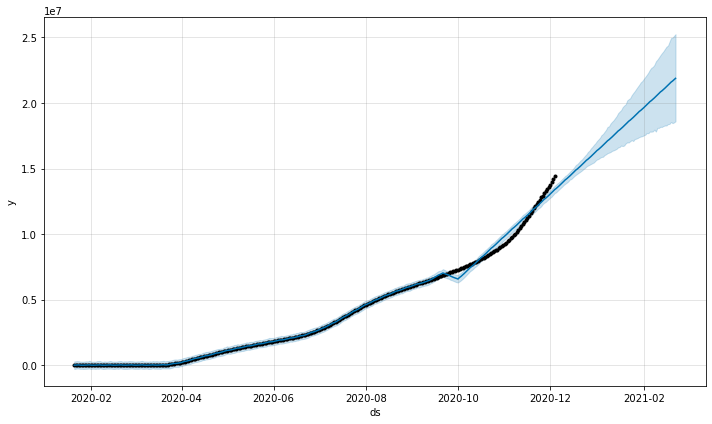

In [10]:
m = Prophet(changepoint_prior_scale= 80)
m.fit(df_pre)
future = m.make_future_dataframe(periods=80)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

In [11]:
tem = pd.DataFrame(columns=['Date','County','casep'])
for i in namelist:
    m = Prophet(changepoint_prior_scale= 80)
    df_train = dfwc[dfwc.ct==i][['Date','casep']].rename(columns={'Date':'ds','casep':'y'})
    m.fit(df_train)
    future = m.make_future_dataframe(periods=200)
    forecast = m.predict(future)
    forecast['County'] = dfwc[dfwc.ct==i].ct.unique()[0]
    forecast['State'] = dfwc[dfwc.ct==i].State.unique()[0]
    tempdf = forecast[['ds','County','yhat','State']].iloc[-200:,:]
    tempdf.columns=['Date','County','casep','State']
    tem = tem.append(tempdf,ignore_index=True)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [12]:
#tem['State'] = None
#for i in np.unique(namelist):
    #ind = tem[tem.County ==i].index
    #tem['State'][ind] = dfwc[dfwc.ct==i]['State'].unique()[0]
tem = tem.rename({'casep':'Casep'},axis=1)

In [13]:
#append dfwc and temp to final dataframe for plot
findf = dfwc[['Date','ct','casep','State']].rename({'ct':'County'},axis=1)
findf = findf.append(tem,ignore_index=True)
#Drop two states that only have 1 county in top 200 infected county
ind = findf[findf.State.isin(['Alaska','Delaware'])].index
findf = findf.drop(ind)
findf.to_csv('findf.csv')

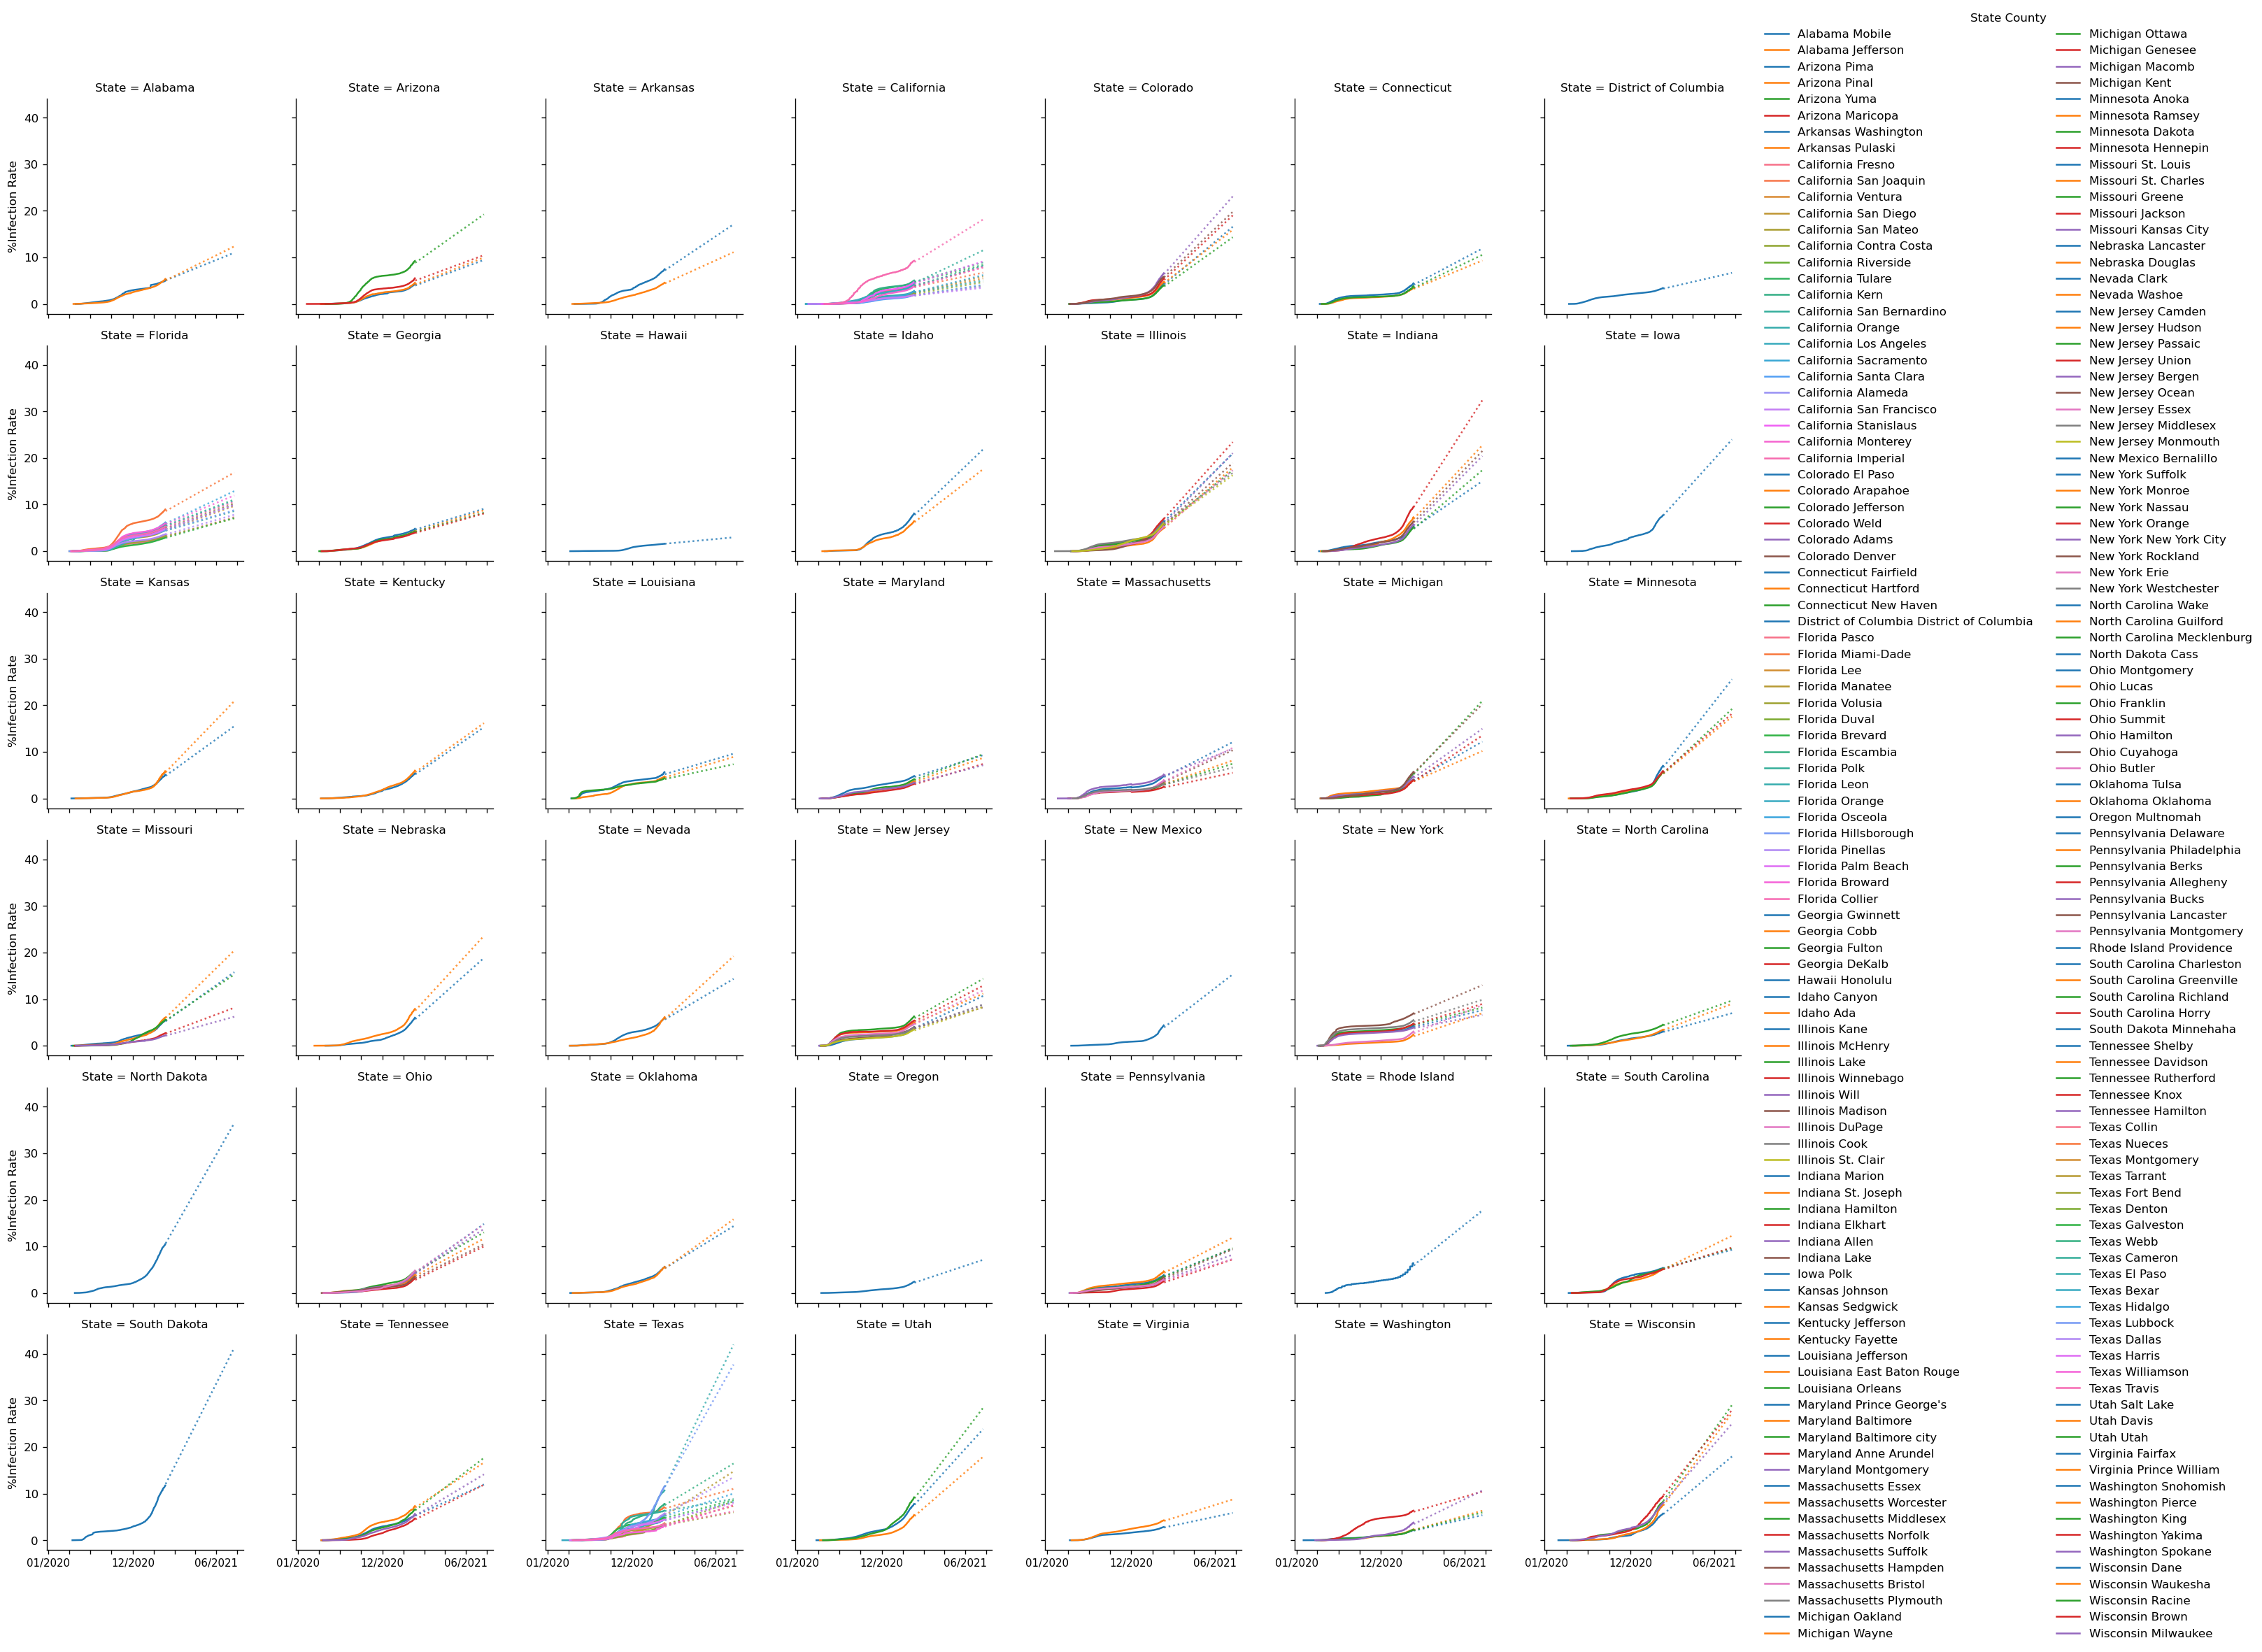

In [14]:
from pylab import rcParams
rcParams['figure.dpi'] = 110
#draw the Top200 county performance by day
a = findf.State.unique().tolist()
a = sorted(a)
g = sns.FacetGrid(findf, col='State', col_wrap=7,col_order=a)
g.map_dataframe(sns.lineplot, x='Date', y='casep',hue='County')
g.map_dataframe(sns.lineplot, x='Date', y='Casep',hue='County',alpha=0.8,linestyle=":")
g.set_ylabels('%Infection Rate')
g.set(xticklabels=['01/2020','','','','12/2020','','','','06/2021','',''])
#g.format_xdata = mdates.DateFormatter('%mm/%YY')
g.set_xticklabels(size = 9)
g.add_legend(ncol=2,loc = 'right')
g._legend.set_title("State County")
g.savefig("output.png")

#title = 'Covid-19 US Top200 Counties infection rate prediction'
#text = "US Top200 counties that're most affected by Covid-19 were analyzed and predicted;\nIn each lineplot, solid line showed history infection% while dotted line predicted trend in 2021;\nSome counties infection rate reached to 15% in 2020 and predicted to be 40% in mid of 2021;\nEach county prediction was based on its own history data in 2020 using fbprophet with tunned parameter."
#Author = "Author: Fred Liu,   Date: Feb.2021,   Data Source: Kaggle Dataset https://www.kaggle.com/kacious/covid-19-us-top200-counties-infection-prediction."
#plt.subplots_adjust(top=0.91)
#g.fig.suptitle(title,fontsize=28,x=0.01,y=0.995,horizontalalignment='left')
#g.fig.text(x=0.01, y=0.937,s = text,color="gray",fontsize=20,horizontalalignment='left')
#g.fig.text(x=0.01, y=0.923,s = Author,color="gray",fontsize=18,horizontalalignment='left',fontstyle='italic')

In [15]:
m = Prophet(changepoint_prior_scale= 80)
m.fit(df_pre)
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = m.plot(forecast)
px.area(forecast, x='ds', y='yhat')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
%matplotlib notebook
g.savefig("output1.png")

<IPython.core.display.Javascript object>


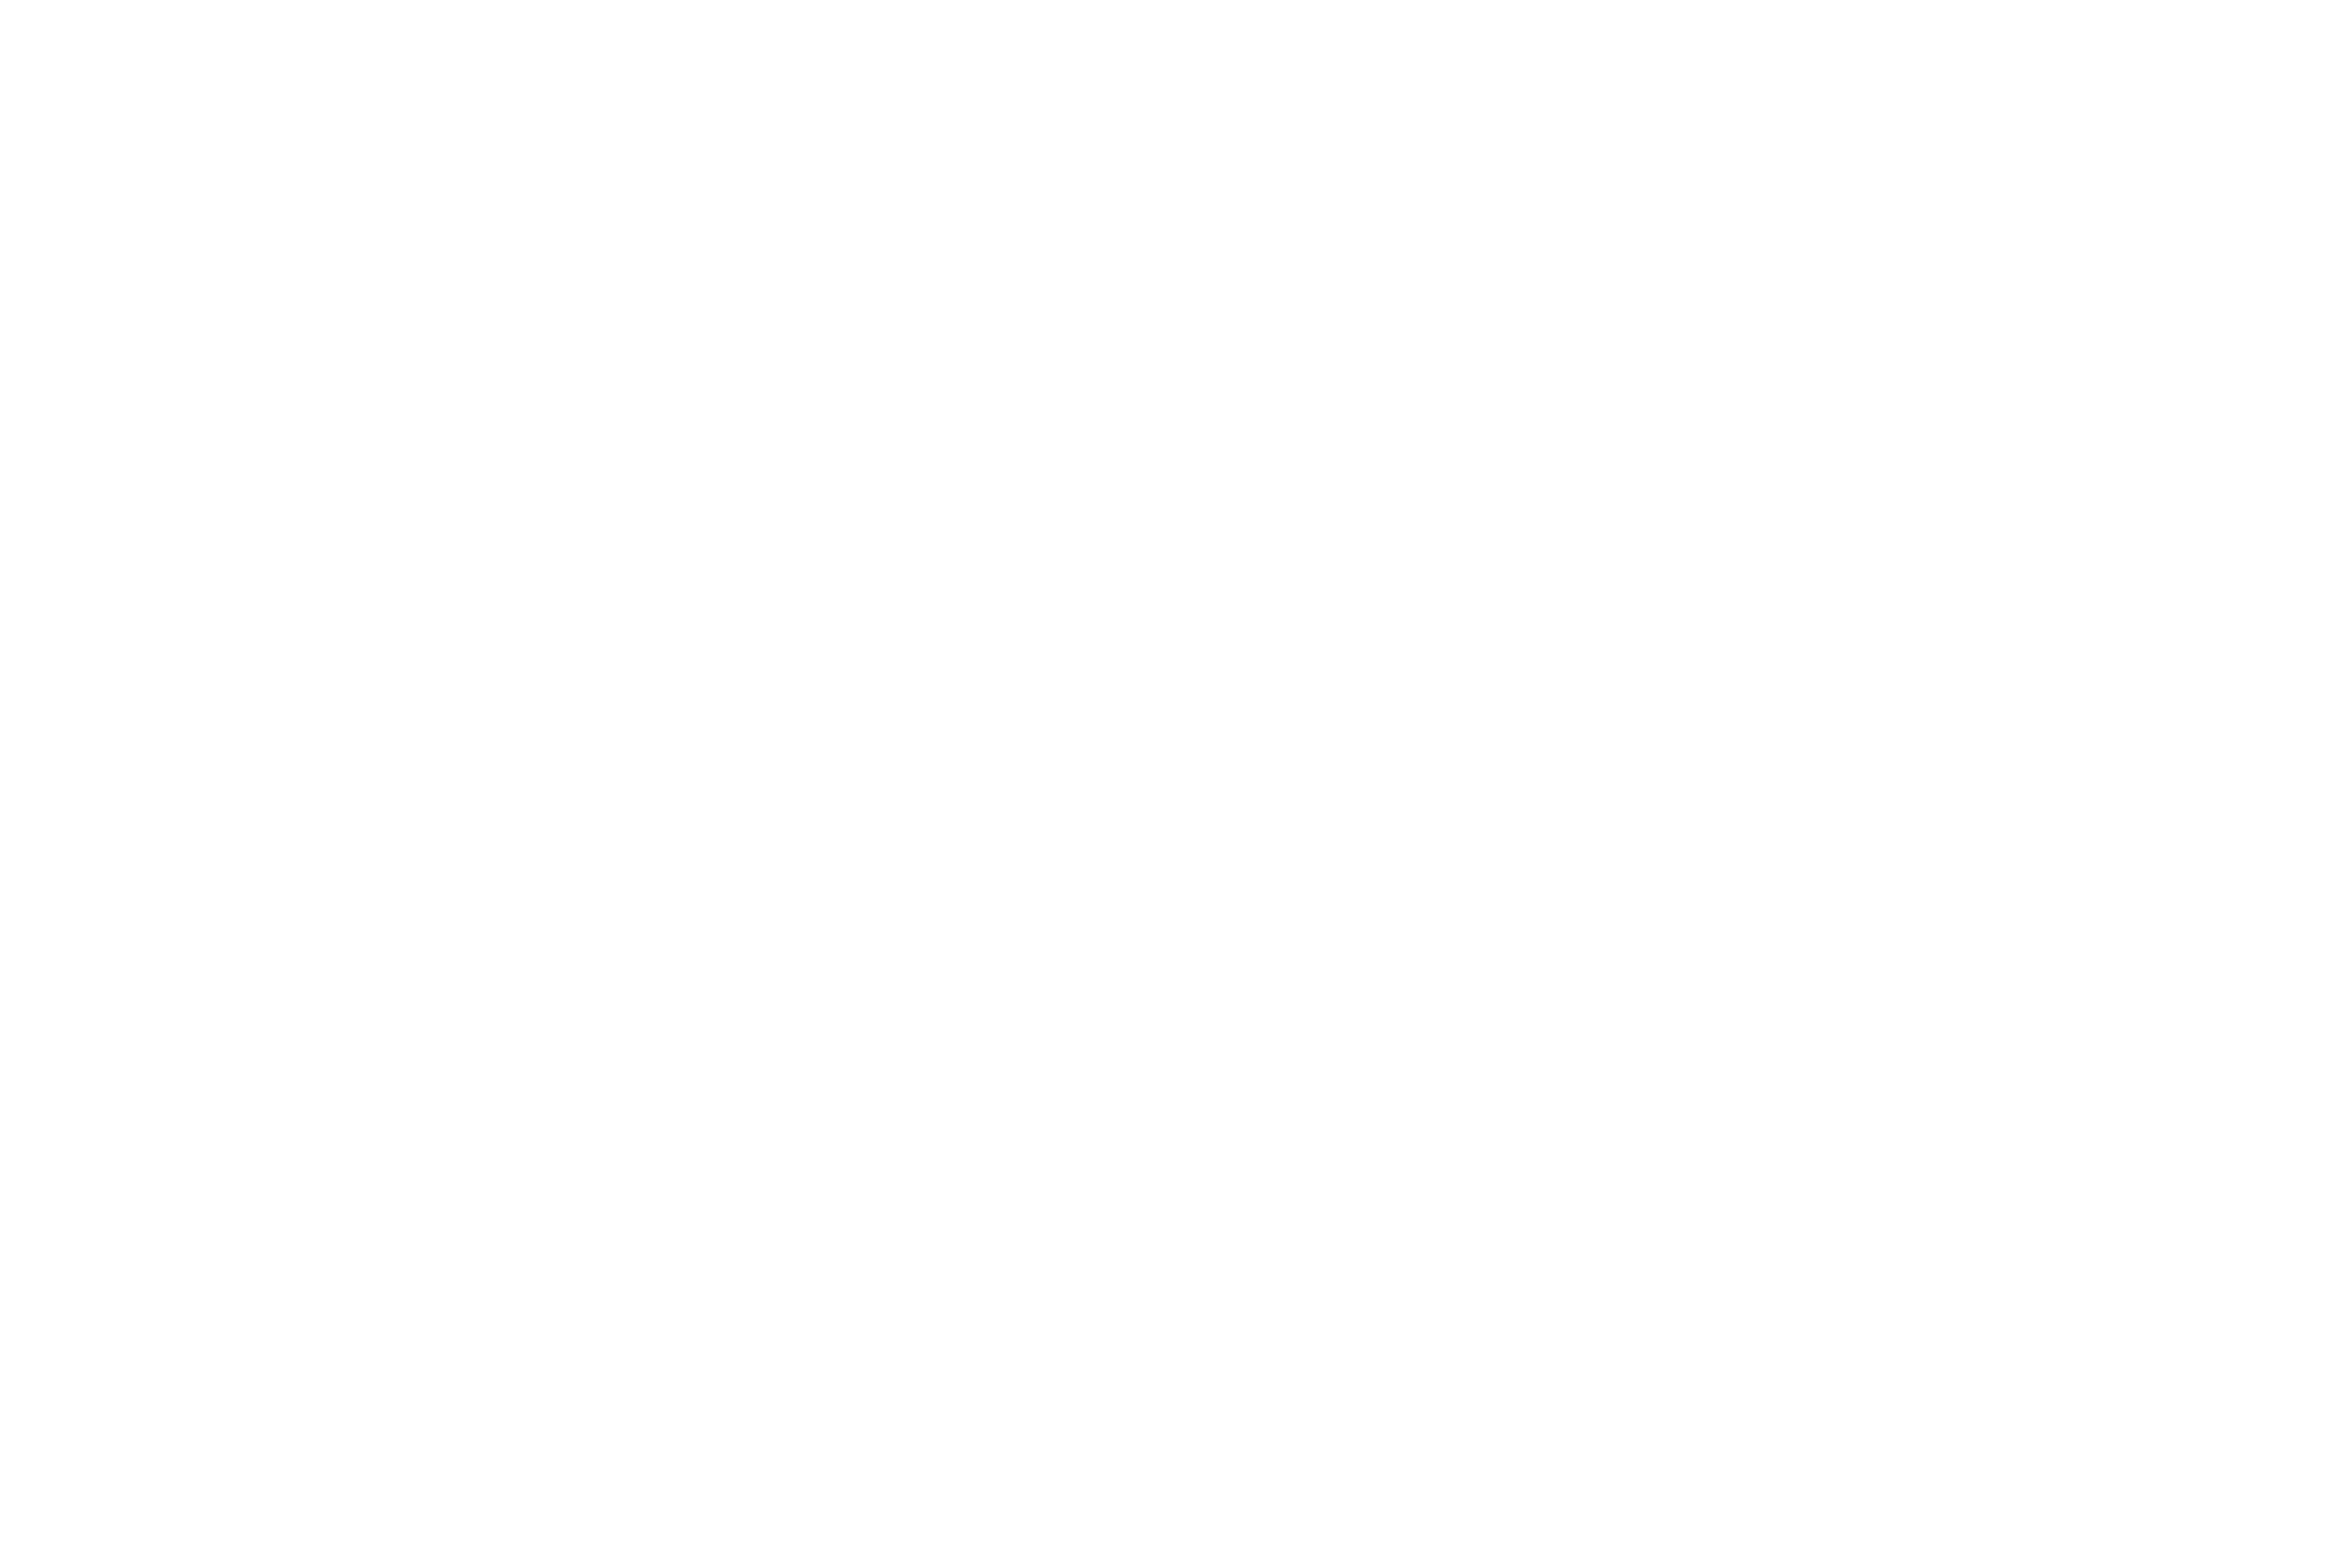

<IPython.core.display.Javascript object>


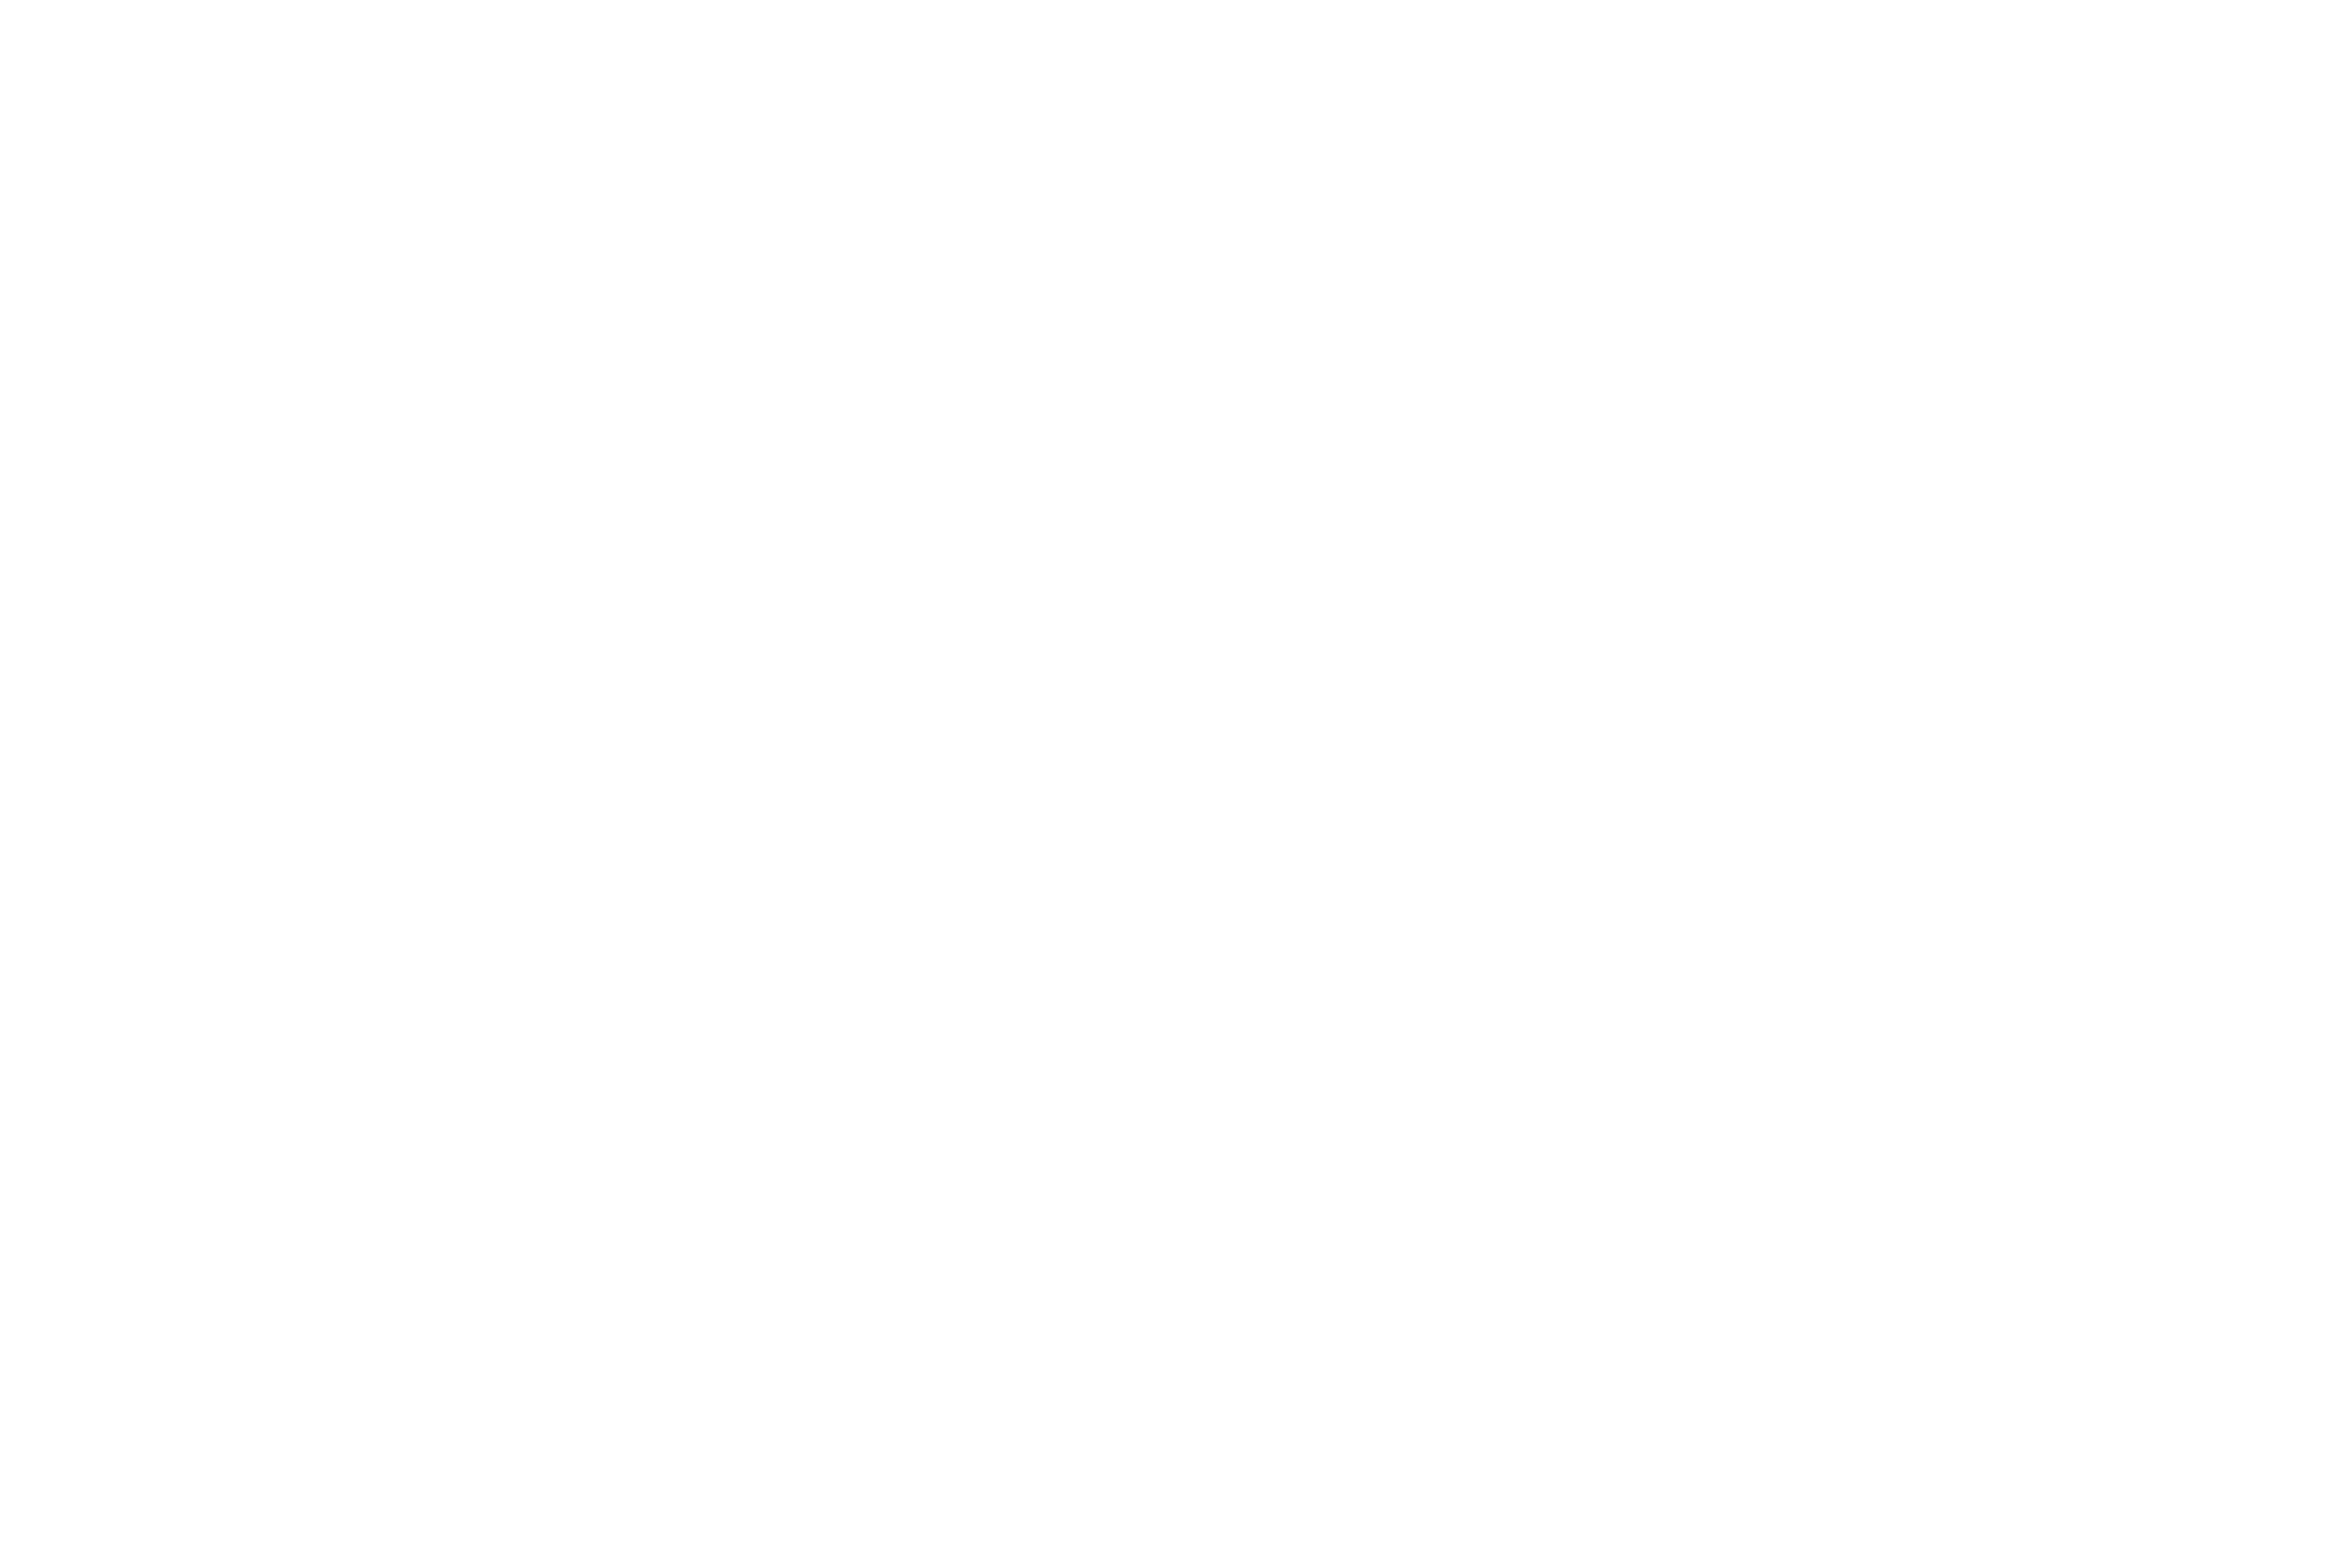

In [17]:
from matplotlib.pyplot import figure
figure(dpi=180)